
# Projeto DS – Parte I (Concessões INSS – 05/2023)

## Resumo do dataset

Este notebook trabalha com um recorte público de concessões de benefícios do INSS referente à competência **maio/2023**. O arquivo reuni informações essenciais do benefício concedido e do perfil do beneficiário. Entre as variáveis, destacam-se: `Competência concessão` (mês/ano de referência), `Espécie` (tipo do benefício, como **Aposentadoria por Idade**, **Pensão por Morte Previdenciária**, **Auxílio‑Doença Previdenciário**, **Salário‑Maternidade** e o benefício assistencial **BPC/Amparo Social**), `CID` (Classificação Internacional de Doenças, quando informado; o rótulo “Zerados” indica ausência), `Despacho` (modalidade da decisão), `Dt Nascimento`, `Sexo.`, `Clientela` (Urbano/Rural), `Mun Resid` e `UF` (local de residência), `Forma Filiação`, `Vínculo dependentes` e `Qt SM RMI` (valor inicial expresso em salários mínimos).

O objetivo desta parte do projeto é produzir um **panorama descritivo** que sirva de base para as próximas etapas analíticas. Com esse conjunto é possível: (i) caracterizar o **perfil demográfico** dos beneficiários (idade na concessão e distribuição por sexo); (ii) comparar **espécies** de benefícios em termos de volume de concessões, idade média de concessão e valor inicial; (iii) investigar **diferenças regionais** por UF e município; e (iv) relacionar **clientela** e **forma de filiação** com a remuneração inicial medida em salários mínimos.

Como preparação, converti `Competência concessão` em uma **data de concessão** fixada no primeiro dia do mês (a granularidade da fonte é mensal). Em seguida, fiz o parse de `Dt Nascimento` usando o formato brasileiro (dia/mês/ano) e calculei a variável `idade_anos` como a diferença, em anos completos, entre a data de concessão e a data de nascimento. Padronizei os valores de `Sexo.` para evitar variações de capitalização e converti `Qt SM RMI` de texto com **vírgula decimal** para número de ponto flutuante. Para `CID`, criei ainda um **indicador de ausência** que considera tanto valores nulos quanto o rótulo “Zerados”, frequente na base.

As análises apresentadas nesta Parte I abrangem: **identificação de valores ausentes**, gráficos **univariados** (top 10 espécies; histograma de idades), visualizações **bivariadas** (idade por sexo; RMI média por clientela) e uma visualização **multivariada** com **três variáveis** (espécie × sexo × contagem) que ajuda a comparar padrões entre grupos. Cada visual é acompanhado por **resumos numéricos** e **interpretações** que se conectam diretamente às perguntas de interesse do projeto. Como limitações, ressalto que o arquivo cobre **apenas uma competência** (202305), portanto as conclusões são **descritivas e temporais**; a presença de `CID` “Zerados” reduz a capacidade de análise por diagnóstico; e a ausência de variáveis socioeconômicas mais detalhadas limita inferências causais. **Ainda assim, o volume e a diversidade de categorias permitem um diagnóstico inicial robusto** do padrão de concessões no período.



## Perguntas e hipóteses de interesse

1. **Sexo e concessão**  
   - **P1:** Há diferença na distribuição de concessões por **sexo**?  
   - **H0:** As proporções entre Feminino e Masculino são iguais.  
   - **H1:** Existe diferença relevante nas proporções.

2. **Idade e espécie**  
   - **P2:** A **idade média de concessão** varia entre **espécies** de benefício?  
   - **H0:** Idades médias iguais entre espécies.  
   - **H1:** Há diferenças de idade entre espécies (ex.: maternidade → idades mais baixas).

3. **Clientela e valor inicial**  
   - **P3:** A **clientela** (Urbano vs. Rural) se associa a diferenças na **RMI em salários mínimos**?  
   - **H0:** RMI média igual entre as clientelas.  
   - **H1:** RMI média difere (ex.: variações por regras de cálculo e perfil contributivo).

4. **Espécie, sexo e contagem**  
   - **P4:** Quais espécies concentram mais concessões por **sexo**?  
   - **Hipótese:** Benefícios como **Salário‑Maternidade** são concentrados no sexo feminino; aposentadorias podem estar mais equilibradas.

5. **CID ausente**  
   - **P5:** Qual o percentual de **CID ausente** (incluindo “Zerados”) e como isso pode afetar análises por diagnóstico?


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# 1️⃣ Montar o Google Drive
drive.mount('/content/drive')

# 2️⃣ Definir o caminho da pasta onde está o CSV
folder_path = "/content/drive/MyDrive/Colab Notebooks"

# 3️⃣ Nome do arquivo CSV
csv_file = "D.SDA.PDA.001.CON.202305.csv"
csv_path = f"{folder_path}/{csv_file}"

# 4️⃣ Carregar CSV
df = pd.read_csv(csv_path, sep=";", low_memory=False, encoding="latin1")

# 5️⃣ Limpeza / engenharia de atributos
col_comp = 'Competência concessão'
col_nasc = 'Dt Nascimento'
col_sexo = 'Sexo.'
col_esp = 'Espécie'
col_cid = 'CID'
col_clientela = 'Clientela'
col_uf = 'UF'
col_qt_sm = 'Qt SM RMI'

# Datas
df['_comp_str'] = df[col_comp].astype(str)
df['data_concessao'] = pd.to_datetime(df['_comp_str'] + '01', format='%Y%m%d', errors='coerce')
df['dt_nascimento'] = pd.to_datetime(df[col_nasc], dayfirst=True, errors='coerce')

# Idade (anos)
df['idade_anos'] = np.floor((df['data_concessao'] - df['dt_nascimento']).dt.days / 365.25)

# RMI em SM (converter vírgula decimal)
df['qt_sm_rmi'] = (
    df[col_qt_sm].astype(str).str.strip()
      .str.replace('.', '', regex=False)
      .str.replace(',', '.', regex=False)
)
df['qt_sm_rmi'] = pd.to_numeric(df['qt_sm_rmi'], errors='coerce')

# Sexo padronizado
df['sexo'] = df[col_sexo].astype(str).str.strip().str.title()

# CID ausente (inclui 'Zerados')
df['cid_faltante'] = df[col_cid].isna() | df[col_cid].astype(str).str.strip().str.lower().eq('zerados')

print("Shape:", df.shape)
print(df.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (508583, 20)
   Competência concessão                                        Espécie  \
0                 202305  Amp. Social Pessoa Portadora Deficiencia        
1                 202305  Aposentadoria por Idade                         
2                 202305  Aposentadoria por Idade                         

                                             CID  \
0  G80.9 Paralisia Cerebral Infantil Ne            
1  Zerados                                         
2  Zerados                                         

                                   Despacho Dt Nascimento          Sexo.  \
0  Concessao Normal                            07/05/2022  Masculino       
1  Concessao Normal                            11/02/1963  Masculino       
2  Concessao em Fase Recursal                  09/09/1958  Feminino        

  Clientela           Tipo de Cálcul

In [22]:
print("Colunas disponíveis:", df.columns.tolist())
print("Linhas/Colunas:", df.shape)
print("\nPercentual de valores ausentes por coluna (%):")
print((df.isna().mean()*100).round(2))
# Verifica a coluna do RMI já convertida para numérico ('qt_sm_rmi'):
print("\nAmostra de 'qt_sm_rmi' (5 primeiras):", df['qt_sm_rmi'].head().tolist())
print("\nResumo estatístico rápido de 'qt_sm_rmi':")
print(df['qt_sm_rmi'].describe().round(2))


Colunas disponíveis: ['Competência concessão', 'Espécie', 'CID', 'Despacho', 'Dt Nascimento', 'Sexo.', 'Clientela', 'Tipo de Cálculo', 'Mun Resid', 'Vínculo dependentes', 'Forma Filiação', 'UF', 'Qt SM RMI', '_comp_str', 'data_concessao', 'dt_nascimento', 'idade_anos', 'qt_sm_rmi', 'sexo', 'cid_faltante']
Linhas/Colunas: (508583, 20)

Percentual de valores ausentes por coluna (%):
Competência concessão    0.0
Espécie                  0.0
CID                      0.0
Despacho                 0.0
Dt Nascimento            0.0
Sexo.                    0.0
Clientela                0.0
Tipo de Cálculo          0.0
Mun Resid                0.0
Vínculo dependentes      0.0
Forma Filiação           0.0
UF                       0.0
Qt SM RMI                0.0
_comp_str                0.0
data_concessao           0.0
dt_nascimento            0.0
idade_anos               0.0
qt_sm_rmi                0.0
sexo                     0.0
cid_faltante             0.0
dtype: float64

Amostra de 'qt_sm_rm


## Identificação de valores ausentes

Cálculo da taxa de `NaN` por coluna e criação de um indicador específico para `CID` ausente (incluindo o rótulo “Zerados”).


In [23]:

missing = df.isna().mean().sort_values(ascending=False) * 100
print(missing.round(2))

print("\nPercentual de CID ausente (inclui 'Zerados'):", round(100*df['cid_faltante'].mean(),2), "%")


Competência concessão    0.0
Espécie                  0.0
CID                      0.0
Despacho                 0.0
Dt Nascimento            0.0
Sexo.                    0.0
Clientela                0.0
Tipo de Cálculo          0.0
Mun Resid                0.0
Vínculo dependentes      0.0
Forma Filiação           0.0
UF                       0.0
Qt SM RMI                0.0
_comp_str                0.0
data_concessao           0.0
dt_nascimento            0.0
idade_anos               0.0
qt_sm_rmi                0.0
sexo                     0.0
cid_faltante             0.0
dtype: float64

Percentual de CID ausente (inclui 'Zerados'): 53.75 %



## Visualizações univariadas

### 1) Top 10 **Espécies** (contagem)


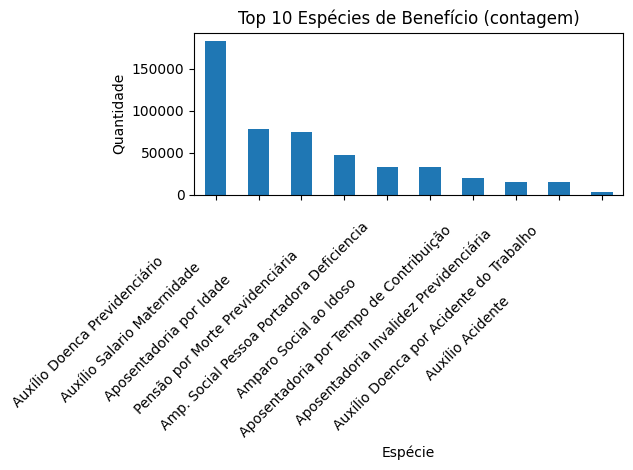

In [24]:

top_especies = df['Espécie'].value_counts().head(10)
plt.figure()
top_especies.plot(kind='bar')
plt.title('Top 10 Espécies de Benefício (contagem)')
plt.xlabel('Espécie')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### 2) Distribuição de **Idade** na concessão


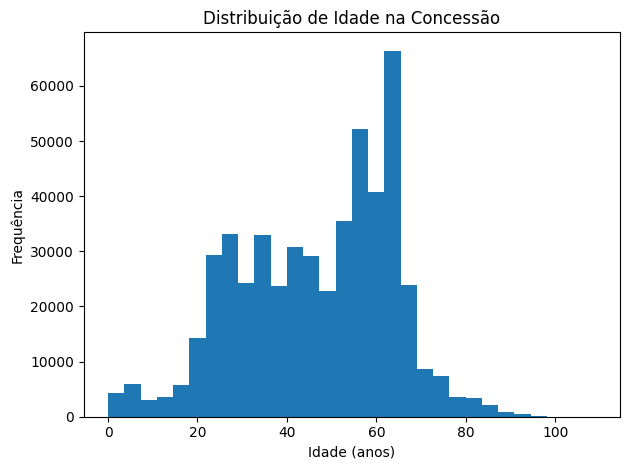

In [25]:

idade_validas = df['idade_anos'].dropna()
plt.figure()
plt.hist(idade_validas, bins=30)
plt.title('Distribuição de Idade na Concessão')
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()



## Visualizações bivariadas

### 1) **Idade × Sexo** (boxplot)


<Figure size 640x480 with 0 Axes>

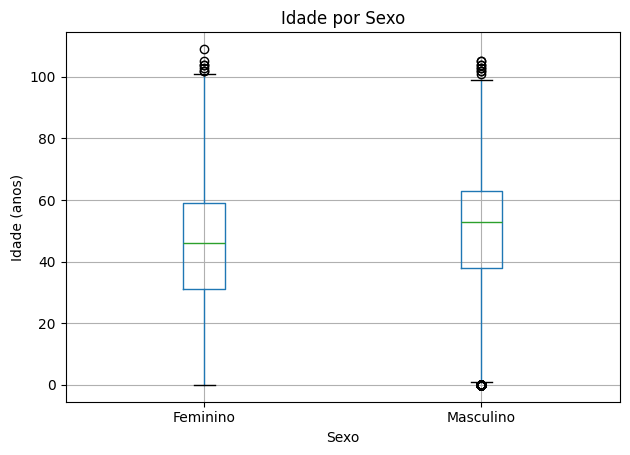

In [26]:

plt.figure()
df.boxplot(column='idade_anos', by='sexo')
plt.title('Idade por Sexo')
plt.suptitle('')
plt.xlabel('Sexo')
plt.ylabel('Idade (anos)')
plt.tight_layout()
plt.show()



### 2) **RMI (salários mínimos) × Clientela** (médias)


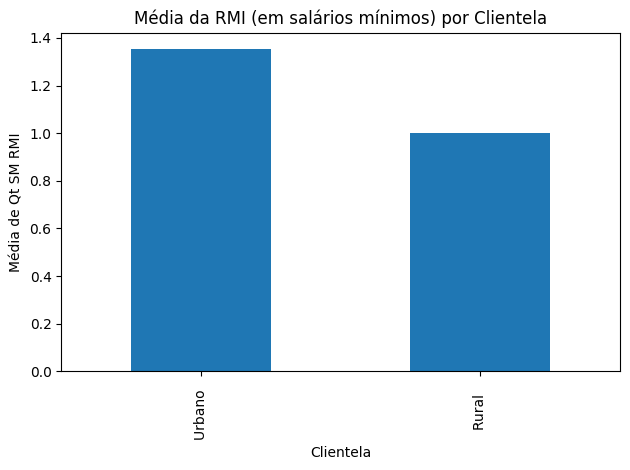

In [27]:

medias_sm = df.groupby('Clientela')['qt_sm_rmi'].mean().dropna().sort_values(ascending=False)
plt.figure()
medias_sm.plot(kind='bar')
plt.title('Média da RMI (em salários mínimos) por Clientela')
plt.xlabel('Clientela')
plt.ylabel('Média de Qt SM RMI')
plt.tight_layout()
plt.show()



## Visualização multivariada (3 variáveis)

**Espécie × Sexo × Contagem**: gráfico de barras agrupadas para as 5 espécies mais frequentes, comparando Feminino e Masculino.


<Figure size 640x480 with 0 Axes>

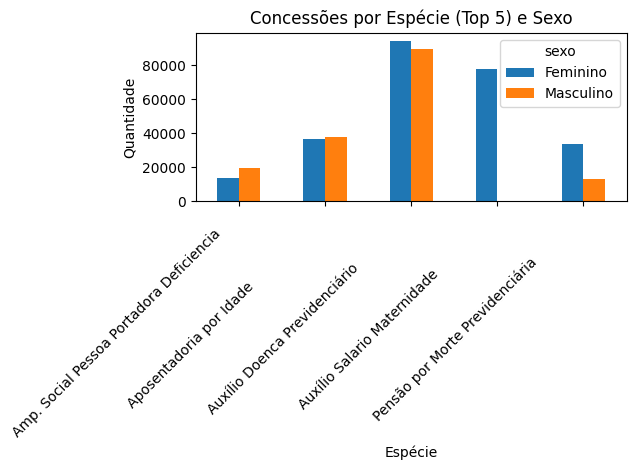

In [28]:

top5 = df['Espécie'].value_counts().head(5).index.tolist()
subset = df[df['Espécie'].isin(top5)].copy()
subset['sexo'] = subset['Sexo.'].astype(str).str.strip().str.title()

import pandas as pd
ct = pd.crosstab(subset['Espécie'], subset['sexo'])

plt.figure()
ct.plot(kind='bar')
plt.title('Concessões por Espécie (Top 5) e Sexo')
plt.xlabel('Espécie')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Resumos numéricos para interpretação


In [29]:

print("Idade média por Espécie (top 10):")
print(df.groupby('Espécie')['idade_anos'].mean().sort_values(ascending=False).round(1).head(10))

print("\nRMI média (salários mínimos) por Espécie (top 10):")
print(df.groupby('Espécie')['qt_sm_rmi'].mean().sort_values(ascending=False).round(2).head(10))


Idade média por Espécie (top 10):
Espécie
Pensão Vitalícia Seringueiros                    88.0
Pensão por Morte de Ex-Combatente                80.5
Pensão Vitalícia Dependentes Seringueiro         77.4
Pensão por Morte de Anistiados                   74.0
Amparo Social ao Idoso                           67.1
Aposentadoria por Idade                          61.7
Pensao Especial Hanseniase Lei 11520/07          59.0
Pensão por Morte Previdenciária                  57.4
Aposentadoria por Tempo de Contribuição          57.2
Aposent. Tempo de Serviço de Professor           56.2
Name: idade_anos, dtype: float64

RMI média (salários mínimos) por Espécie (top 10):
Espécie
Pensão por Morte de Anistiados                   46.45
Pensão por Morte de Ex-Combatente                 4.98
Aposentadoria Especial                            3.46
Pensão por Morte Acidente do Trabalho             2.84
Aposent. Tempo de Serviço de Professor            2.58
Aposentadoria por Tempo de Contribuição           


## Interpretação e vínculo com as perguntas

- **P1 (Sexo e concessão):** O gráfico *Espécie × Sexo* e a contagem total por `Sexo.` permitem verificar a distribuição geral. No dataset de 05/2023 há predominância do sexo feminino, compatível com benefícios como **Salário‑Maternidade** concentrados em mulheres.
- **P2 (Idade e espécie):** A **distribuição de idade** e os **resumos por espécie** mostram perfis distintos: benefícios de maternidade têm idades menores; aposentadorias e pensões apresentam idades mais elevadas.
- **P3 (Clientela e RMI):** A barra de **RMI média por clientela** indica se há diferença relevante entre **Urbano** e **Rural**, sugerindo impacto de regras de cálculo e vínculos contributivos.
- **P4 (Espécie, sexo e contagem):** O gráfico multivariado evidencia a concentração feminina em **Salário‑Maternidade** e padrões mais equilibrados em **Aposentadoria por Idade** ou **Auxílio‑Doença**.
- **P5 (CID ausente):** A taxa de `cid_faltante` orienta prudência em análises clínicas; recomenda-se excluir casos com `CID` ausente quando a pergunta exigir diagnóstico.






## 6) Distribuição do RMI (em salários mínimos)

Este gráfico complementa a análise de valores, mostrando a distribuição de `qt_sm_rmi` (valor inicial do benefício em salários mínimos).



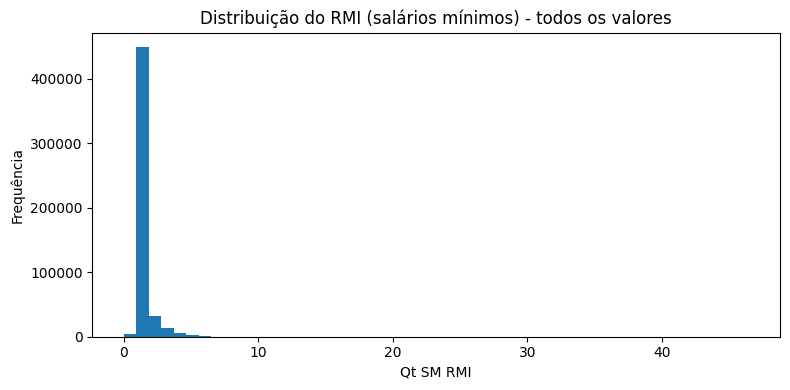

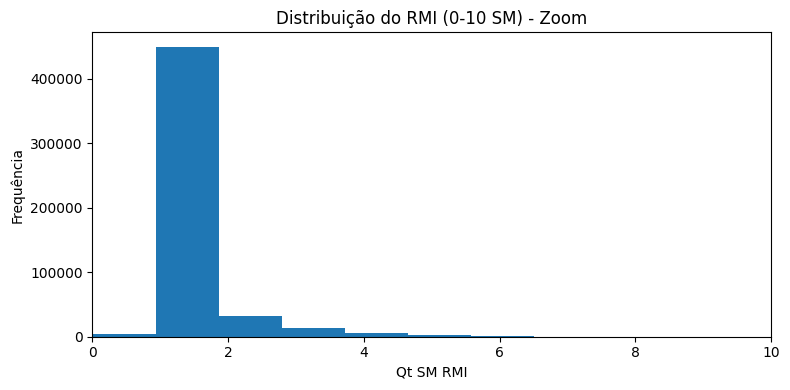

In [30]:

# 6) Distribuição do RMI (em salários mínimos) - dois histogramas (completo + zoom 0-10)
import matplotlib.pyplot as plt

# histograma - todos os valores
plt.figure(figsize=(8,4))
plt.hist(df['qt_sm_rmi'].dropna(), bins=50)
plt.title('Distribuição do RMI (salários mínimos) - todos os valores')
plt.xlabel('Qt SM RMI')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# histograma - zoom (0-10 SM) para visualizar concentração
plt.figure(figsize=(8,4))
plt.hist(df['qt_sm_rmi'].dropna(), bins=50)
plt.xlim(0,10)
plt.title('Distribuição do RMI (0-10 SM) - Zoom')
plt.xlabel('Qt SM RMI')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()
